# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [2]:
DF_NAMES = ['geo_data_0', 'geo_data_1', 'geo_data_2']

## Загрузка и подготовка данных

In [3]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [4]:
geo_data_0.head(5)

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
geo_data_0.duplicated().sum()

0

In [6]:
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
geo_data_1.head(5)

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [8]:
geo_data_1.duplicated().sum()

0

In [9]:
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')
geo_data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [10]:
geo_data_2.head(5)

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [11]:
geo_data_2.duplicated().sum()

0

In [12]:
for f in DF_NAMES:
    print(f"Датафрейм {f}")
    print(f"{(globals()[f]).describe()}")
        
    print('\n')

Датафрейм geo_data_0
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        0.500419       0.250143       2.502647      92.500000
std         0.871832       0.504433       3.248248      44.288691
min        -1.408605      -0.848218     -12.088328       0.000000
25%        -0.072580      -0.200881       0.287748      56.497507
50%         0.502360       0.250252       2.515969      91.849972
75%         1.073581       0.700646       4.715088     128.564089
max         2.362331       1.343769      16.003790     185.364347


Датафрейм geo_data_1
                  f0             f1             f2        product
count  100000.000000  100000.000000  100000.000000  100000.000000
mean        1.141296      -4.796579       2.494541      68.825000
std         8.965932       5.119872       1.703572      45.944423
min       -31.609576     -26.358598      -0.018144       0.000000
25%        -6.298551      -8.267

In [13]:
#список столбцов с категориальными признаками
for f in DF_NAMES:
    print(f'Столбцы датафрейма {f}')
    globals()['col_cat_'] = globals()[f].select_dtypes(include='object').columns.to_list()
    globals()['col_num_'] = [x for x in globals()[f].columns.to_list() if x not in globals()['col_cat_']]
    print(f"Категориальные столбцы: \n {globals()['col_cat_']}\n"
          f"Численные столбцы: \n {globals()['col_num_']} \n")

Столбцы датафрейма geo_data_0
Категориальные столбцы: 
 ['id']
Численные столбцы: 
 ['f0', 'f1', 'f2', 'product'] 

Столбцы датафрейма geo_data_1
Категориальные столбцы: 
 ['id']
Численные столбцы: 
 ['f0', 'f1', 'f2', 'product'] 

Столбцы датафрейма geo_data_2
Категориальные столбцы: 
 ['id']
Численные столбцы: 
 ['f0', 'f1', 'f2', 'product'] 



In [14]:
#удалим id 
geo_data_0 = geo_data_0.drop(['id'], axis=1)
geo_data_1 = geo_data_1.drop(['id'], axis=1)
geo_data_2 = geo_data_2.drop(['id'], axis=1)

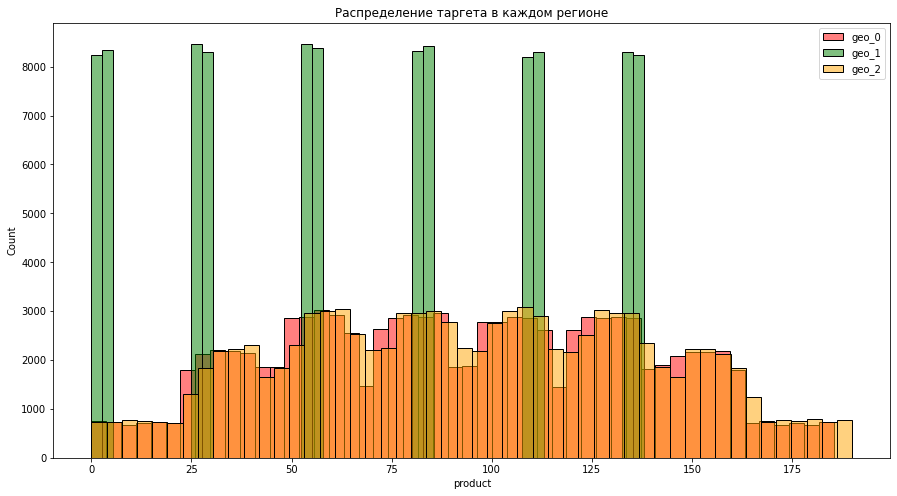

In [15]:
#Распределение Целевого признака product в каждом регионе
fig, ax = plt.subplots(figsize=(15,8))
sns.histplot(data=geo_data_0['product'], ax=ax, bins=50, color='r', alpha = 0.5, label='geo_0')
sns.histplot(data=geo_data_1['product'], ax=ax, bins=50, color='g', alpha = 0.5, label='geo_1')
sns.histplot(data=geo_data_2['product'], ax=ax, bins=50, color='orange', alpha = 0.5, label='geo_2')
ax.set_xlabel('product')
ax.set_title('Распределение таргета в каждом регионе')
plt.legend()
plt.show()

**Промежуточный Вывод**

Датасеты geo_data_0, geo_data_1 и geo_data_2 содержат по 10 000 строк. Пропуски, дубликаты отсутствуют. Все признаки имеют числовое представление. Имена столбцов приведены к стилю lower_case. Продукт распределен между регионами неравномерно. Распределение обьема нефти в 1-ом регионе сильно отличается от двух других, в каждой скважине находится намного больше продукта.

## Обучение и проверка модели

Данные необходимо разбить в соотвествии с заданием на обучающую и валидационную выборки в пропорции 75:25. 

In [16]:
def create_sample(dict_):
    df = list(dict_.values())[0]
    name = list(dict_.keys())[0]
    features = df.drop('product', axis=1)
    target = df['product']
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                                  target,
                                                                                  test_size=0.25,
                                                                                  random_state=12345)
    print(f'Весь датасет региона {name}')
    print('features_train.shape = ', features_train.shape, 'target_train.shape = ', target_train.shape)
    print('features_valid.shape = ', features_valid.shape, 'target_valid.shape = ', target_valid.shape)
    
    # масштабируем признаки
    scaler = StandardScaler()
    scaler.fit(features_train)

    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    return features_train, features_valid, target_train.reset_index(drop=True), target_valid.reset_index(drop=True)

In [17]:
geo_data_0_features_train, geo_data_0_features_valid, geo_data_0_target_train, geo_data_0_target_valid = create_sample({'geo_data_0': geo_data_0})
geo_data_1_features_train, geo_data_1_features_valid, geo_data_1_target_train, geo_data_1_target_valid = create_sample({'geo_data_1': geo_data_1})
geo_data_2_features_train, geo_data_2_features_valid, geo_data_2_target_train, geo_data_2_target_valid = create_sample({'geo_data_2': geo_data_2})

Весь датасет региона geo_data_0
features_train.shape =  (75000, 3) target_train.shape =  (75000,)
features_valid.shape =  (25000, 3) target_valid.shape =  (25000,)
Весь датасет региона geo_data_1
features_train.shape =  (75000, 3) target_train.shape =  (75000,)
features_valid.shape =  (25000, 3) target_valid.shape =  (25000,)
Весь датасет региона geo_data_2
features_train.shape =  (75000, 3) target_train.shape =  (75000,)
features_valid.shape =  (25000, 3) target_valid.shape =  (25000,)


Обучение и предсказание моделей

In [18]:
def fit_predict(features_train, features_valid, target_train, target_valid):
    model = LinearRegression()
    model.fit(features_train,target_train)
    predicted_train = model.predict(features_train)
    predicted_valid = model.predict(features_valid)
    return mean_squared_error(target_train, predicted_train) ** 0.5, \
           mean_squared_error(target_valid, predicted_valid) ** 0.5, predicted_valid

In [19]:
rmse_geo_data_0_train, rmse_geo_data_0_valid, predicted_valid_geo_data_0 = fit_predict(geo_data_0_features_train, geo_data_0_features_valid, geo_data_0_target_train, geo_data_0_target_valid)
rmse_geo_data_1_train, rmse_geo_data_1_valid, predicted_valid_geo_data_1 = fit_predict(geo_data_1_features_train, geo_data_1_features_valid, geo_data_1_target_train, geo_data_1_target_valid)
rmse_geo_data_2_train, rmse_geo_data_2_valid, predicted_valid_geo_data_2 = fit_predict(geo_data_2_features_train, geo_data_2_features_valid, geo_data_2_target_train, geo_data_2_target_valid)

Выведем ошибку и среднее значения предсказанных результатов (объем добываемого продукта в скважине) для каждого региона.

In [20]:
print('Регион GEO_0')
print('RMSE(train):', rmse_geo_data_0_train, '\nRMSE(valid):', rmse_geo_data_0_valid, '\nmean(train):', predicted_valid_geo_data_0.mean())

Регион GEO_0
RMSE(train): 37.72999219904026 
RMSE(valid): 37.5794217150813 
mean(train): 92.59256778438035


In [21]:
print('Регион GEO_1')
print('RMSE(train):', rmse_geo_data_1_train, '\nRMSE(valid):', rmse_geo_data_1_valid, '\nmean(train):', predicted_valid_geo_data_1.mean())

Регион GEO_1
RMSE(train): 0.8894720773917386 
RMSE(valid): 0.893099286775617 
mean(train): 68.728546895446


In [22]:
print('Регион GEO_2')
print('RMSE(train):', rmse_geo_data_2_train, '\nRMSE(valid):', rmse_geo_data_2_valid, '\nmean(train):', predicted_valid_geo_data_2.mean())

Регион GEO_2
RMSE(train): 40.06425978832384 
RMSE(valid): 40.02970873393434 
mean(train): 94.96504596800489


**Промежуточный Вывод**

Данные корректно разбиты на обучающую и валидационную выборки в пропорции 75:25, индексы выборок обновлены, данные сохранены.

Лучше всего модель предсказала запасы во втором регионе (RMSE - 0.88), далее в первом и третьем соотвественно.

## Подготовка к расчёту прибыли

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения выбирают 200 лучших для разработки. Бюджет на разработку скважин в регионе — 10 млрд рублей. При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей. После оценки рисков нужно оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбирают регион с наибольшей средней прибылью. Данные синтетические: детали контрактов и характеристики месторождений не разглашаются.

In [23]:
budget=1e+07
revenue=450
all_points=500
best_points=200

Расчитаем минимальное среднее количество продукта в месторождениях региона, достаточное для разработки. Поделим бюдет региона на число возможных разрабатываем точек, получим минимальный доход со скважины в рублях.

In [24]:
unique_budget=budget/best_points
print('Средняя прибыль на лучшую точку -', unique_budget, 'тыс.руб.')

Средняя прибыль на лучшую точку - 50000.0 тыс.руб.


Безубыточный объем скважины

In [25]:
profit_level=unique_budget/revenue
print('Средний объем нефти на точку -', profit_level, 'тыс. барелей')

Средний объем нефти на точку - 111.11111111111111 тыс. барелей


In [26]:
average_barrels = budget / revenue
print('Средний объем нефти на регион -', average_barrels, 'тыс. барелей')

Средний объем нефти на регион - 22222.222222222223 тыс. барелей


Получилось, что для безубыточной добычи топлива необходимо, чтобы каждая скважина в среднем содержала не менее 111 тысяч баррелей. Составим сводную таблицу для регионов и сравним его показатель с минимальным средним количеством продукта:

In [27]:
print('Средний запас фактичекой нефти на скважину в регионе 1', geo_data_0['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 2', geo_data_1['product'].mean())
print('Средний запас фактичекой нефти на скважину в регионе 3', geo_data_2['product'].mean())

Средний запас фактичекой нефти на скважину в регионе 1 92.50000000000001
Средний запас фактичекой нефти на скважину в регионе 2 68.82500000000002
Средний запас фактичекой нефти на скважину в регионе 3 95.00000000000004


In [28]:
def oil_profit_calculation(target, probabilities, count):
    probs_sorted = probabilities.sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    return price_per_barrel * selected.sum() - budget

In [29]:
mean_product_pivot = pd.DataFrame({'mean_product': [predicted_valid_geo_data_0.mean(), predicted_valid_geo_data_1.mean(), predicted_valid_geo_data_2.mean()],
                                   'profit_level': [profit_level]*3})
mean_product_pivot['good_region'] = mean_product_pivot['mean_product'] > mean_product_pivot['profit_level']
mean_product_pivot

,mean_product,profit_level,good_region
0,92.592568,111.111111,False
1,68.728547,111.111111,False
2,94.965046,111.111111,False


In [36]:
def calc_income_in_region(target_valid_subsample, predicted_valid_subsample):
    select_predicted_profit_best = predicted_valid_subsample.sort_values(ascending=False)
    target_best = target_valid_subsample[select_predicted_profit_best.index][:best_points]
    return target_best.sum() * revenue - budget

**Промежуточный Вывод**

Средняя прибыль на лучшую точку - 50000.0 тыс.руб. Средний объем нефти на точку - 111.11111111111111 тыс. барелей. Получилось, что для безубыточной добычи топлива необходимо, чтобы каждая скважина в среднем содержала не менее 111 тысяч баррелей. Больше всего среднего запаса фактичекой нефти на скважину в регионе 3.  Если задействовать все скважины в каждом регионе, то прибыли не получиться, нужно отобрать лучшие скважины. 

## Расчёт прибыли и рисков 

In [31]:
def bootstrap_method_calc_income_in_region(target_valid_, predicted_valid_):
    bootstrap = []
    state=np.random.RandomState(12345)
    for _ in range(1000):
        target_valid_subsample = pd.Series(target_valid_).sample(n=all_points, random_state=state, replace=True)
        predicted_valid_subsample = pd.Series(predicted_valid_)[target_valid_subsample.index]
        bootstrap.append(calc_income_in_region(target_valid_subsample, predicted_valid_subsample))
    return pd.Series(bootstrap)

In [32]:
def calc_confidence_interval(interval, massive):
    left_interval = (1 - interval)/2
    right_interval = interval + (1 - interval)/2
    average = massive.mean()
    lower = massive.quantile(left_interval)
    upper = massive.quantile(right_interval)
    risk = (massive < 0).mean()
    print(f'{left_interval:.2%}-квантиль: {lower:.0f} руб. < Средняя прибыль: {average:.0f} руб. < {right_interval:.2%}-квантиль: {upper:.0f} руб. < Риск: {100 * risk:.1f}%')
    return average, lower, upper

Добавила риск, это значения меньше нуля в %

In [37]:
geo_data_0_income_in_region = bootstrap_method_calc_income_in_region(geo_data_0_target_valid, predicted_valid_geo_data_0)
calc_confidence_interval(.95, geo_data_0_income_in_region)
print('Данные по первому региону.')

2.50%-квантиль: 12948 руб. < Средняя прибыль: 600735 руб. < 97.50%-квантиль: 1231164 руб. < Риск: 2.0%
Данные по первому региону.


In [38]:
geo_data_1_income_in_region = bootstrap_method_calc_income_in_region(geo_data_1_target_valid, predicted_valid_geo_data_1)
calc_confidence_interval(.95, geo_data_1_income_in_region)
print('Данные по второму региону.')

2.50%-квантиль: 157988 руб. < Средняя прибыль: 665241 руб. < 97.50%-квантиль: 1197642 руб. < Риск: 0.3%
Данные по второму региону.


In [39]:
geo_data_2_income_in_region = bootstrap_method_calc_income_in_region(geo_data_2_target_valid, predicted_valid_geo_data_2)
calc_confidence_interval(.95, geo_data_2_income_in_region)
print('Данные по третьему региону.')

2.50%-квантиль: -12218 руб. < Средняя прибыль: 615560 руб. < 97.50%-квантиль: 1230644 руб. < Риск: 3.0%
Данные по третьему региону.


Наиболее эффективными для разработки представляются скважины второго региона и с точки зрения интервала для распределения прибыли, и с точки зрения риска убытков. По результатам исследования выделенный бюджет целесообразно освоить именно там.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован